# Tutorial: save ArcSim simulation to DGL graph

In [118]:
import dgl
from dgl.data.utils import save_graphs
import torch
import numpy as np
import pywavefront # for loading .obj files
import logging
logging.getLogger().setLevel(logging.CRITICAL) # disable long output due to error ('ms' field not compatible)

## ArcSim installation
You may find the repository with fixes at https://github.com/kaist-silab/arcsim with further instructions
To install it, run the following:

`git clone https://github.com/kaist-silab/arcsim.git && cd arcsim/`

`sudo chmod +x install.sh && sudo ./install.sh`

At this point, you should be ready to go.

## ArcSim simulation and .obj file saving
Let's consider the flag example. In the ArcSim folder, make a new directory called data. Then run:

`bin/arcsim simulate conf/flag.json data/`

(you may also run `simulateoffline` if you cannot visualize on your computer

When the simulation ends (we may do that with `Esc` as well) copy the `conf/flag.json` into the folder where we saved the simulation, in our case`data/` and run:

`bin/arcsim generate data/`

This will generate `.obj` files that we can load into Python. Below, we will use those files to generate the DGL graph.

In [119]:
def obj_to_dgl(obj):
    '''Transforms pywavefront object into DGL graph
    Compatible with ArcSim .obj files
    ==> TODO <=== 
    1) fix code for supporting multiple features
    2) check functions
    3) add timestamps
    4) merge functions into a single to_dgl with checks
    '''
    vert = np.array(obj.vertices)
    mesh = np.array(obj.mesh_list[0].faces)
    # We add the sources and destination through contiguous nodes
    # We should also repeat by switching indexes to have bidirectional graph
    # BEWARE: this will have lots of duplicates, don't think DGL can deal with them natively
    # extend method similar to append
    src = []
    dst = []
    for i, j in zip([0,1,2], [1,2,0]): 
        src.extend(mesh[:,i].tolist()); dst.extend(mesh[:,j].tolist())
        src.extend(mesh[:,j].tolist()); dst.extend(mesh[:,i].tolist())
    graph = dgl.DGLGraph()
    graph.add_nodes(vert.shape[0])
    graph.add_edges(src, dst)
    graph.ndata['x'] = torch.tensor(vert[:,0])
    graph.ndata['y'] = torch.tensor(vert[:,1])
    graph.ndata['z'] = torch.tensor(vert[:,2])
    return graph

scene = pywavefront.Wavefront('data/00002_00.obj', collect_faces=True) # load ArcSim .obj file
graph = obj_to_dgl(scene)

# Save the graph in .bin file format
# save_graphs('data/graph.bin', graph)

/home/botu/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


## Plotting the graph

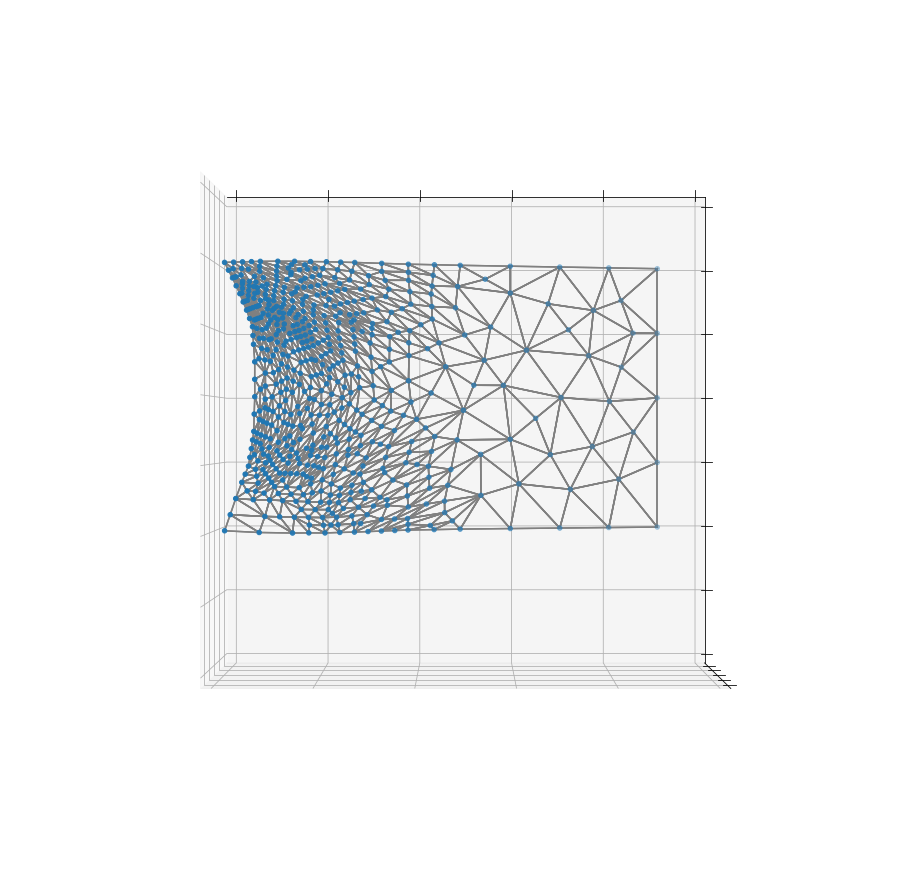

In [113]:
import matplotlib.pyplot as plt

# Data loading
x = graph.ndata['x'].numpy()
y = graph.ndata['y'].numpy()
z = graph.ndata['z'].numpy()
src, dst = graph.edges()


# Plotting
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
lim=2.5
ax.set_xlim3d(0, lim)
ax.set_ylim3d(-1, lim)
ax.set_zlim3d(-lim, lim)
ax.view_init(90, -90)

ax.scatter(x, y, z)
for i in range(len(src)):
    s, d = src[i], dst[i]
    xs, ys, zs = np.array([x[s], x[d]]), np.array([y[s], y[d]]), np.array([z[s], z[d]])
    ax.plot(xs, ys, zs, color='grey')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)

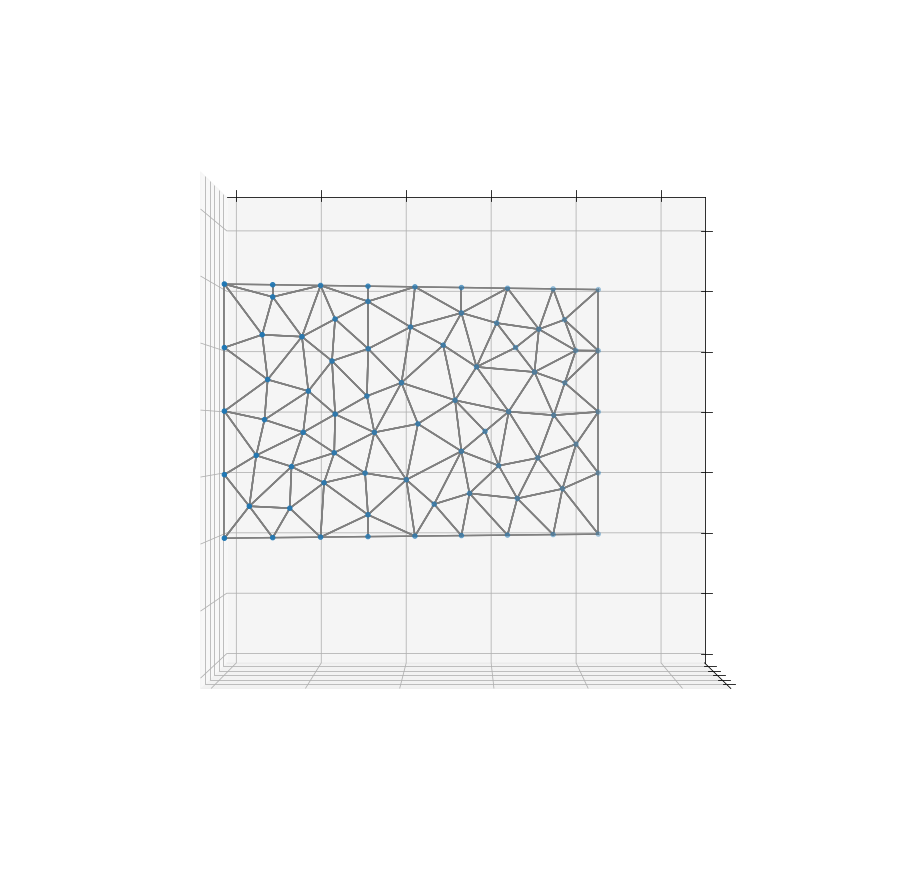

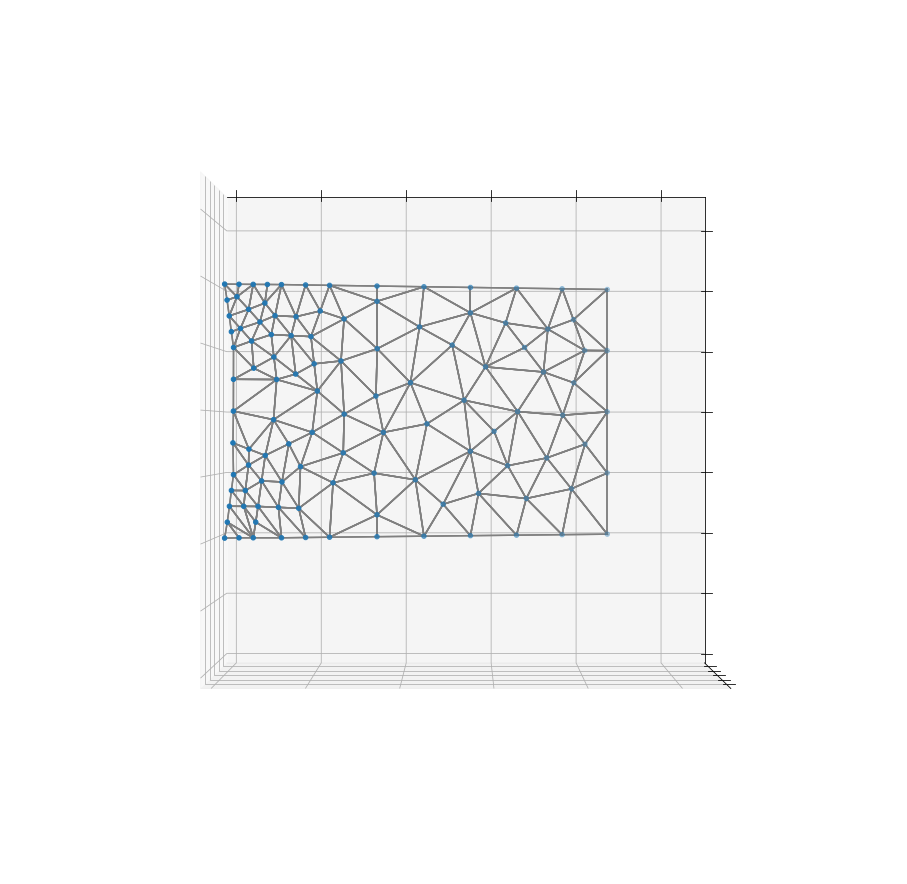

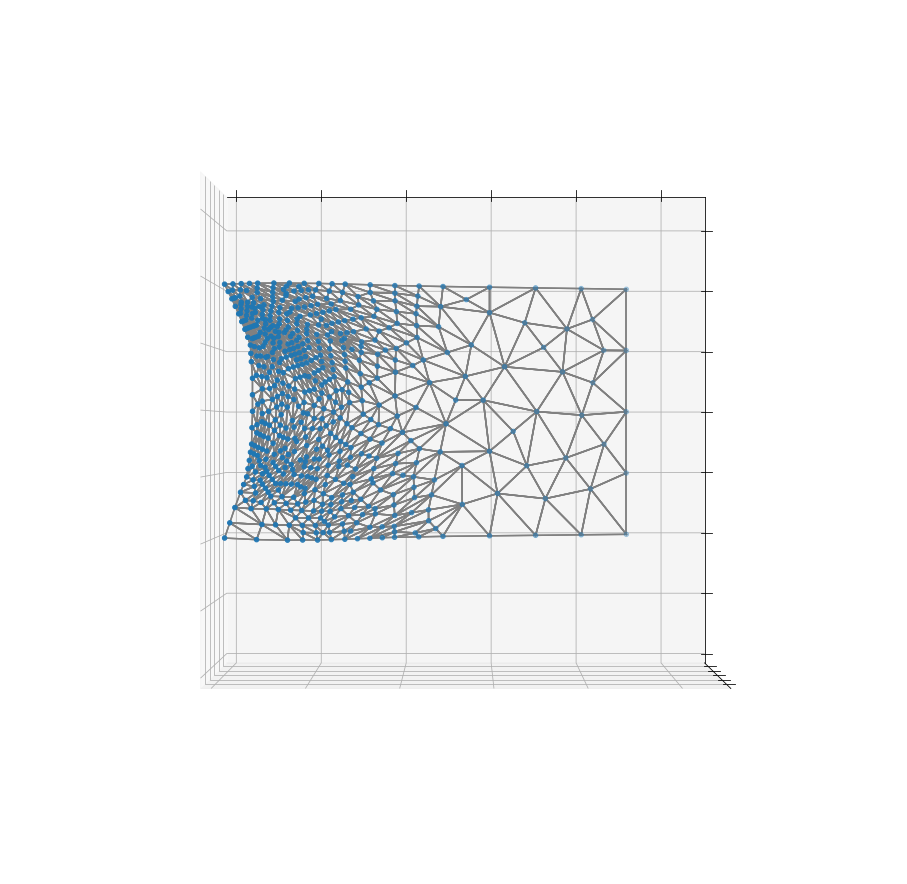

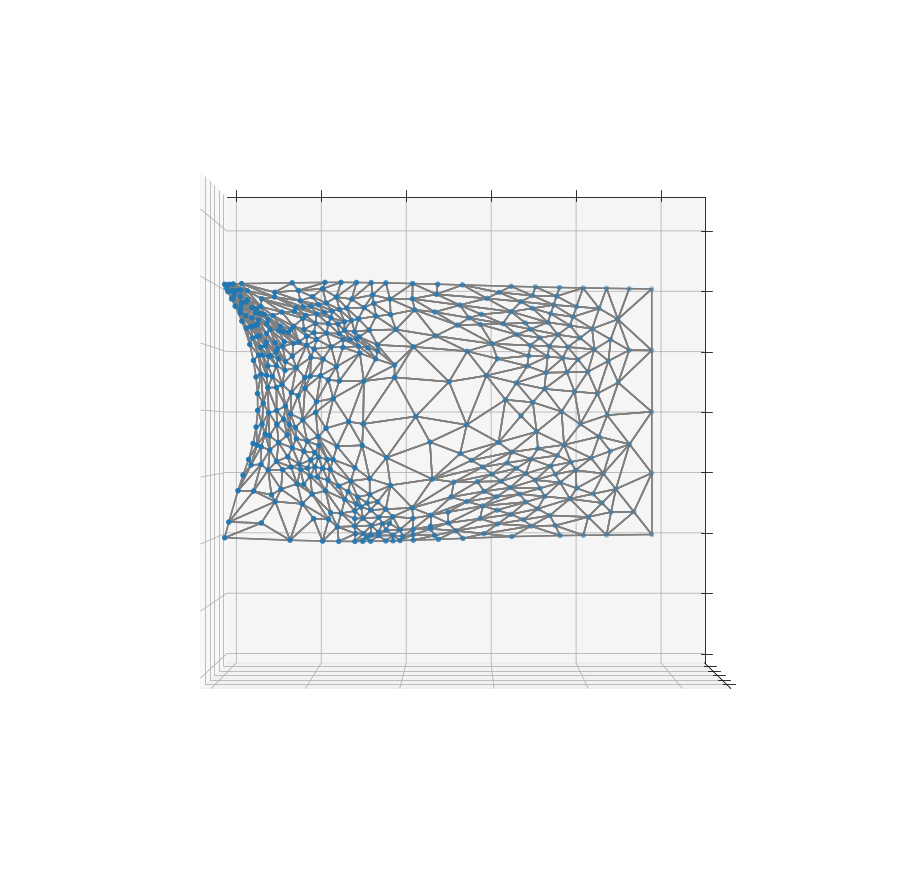

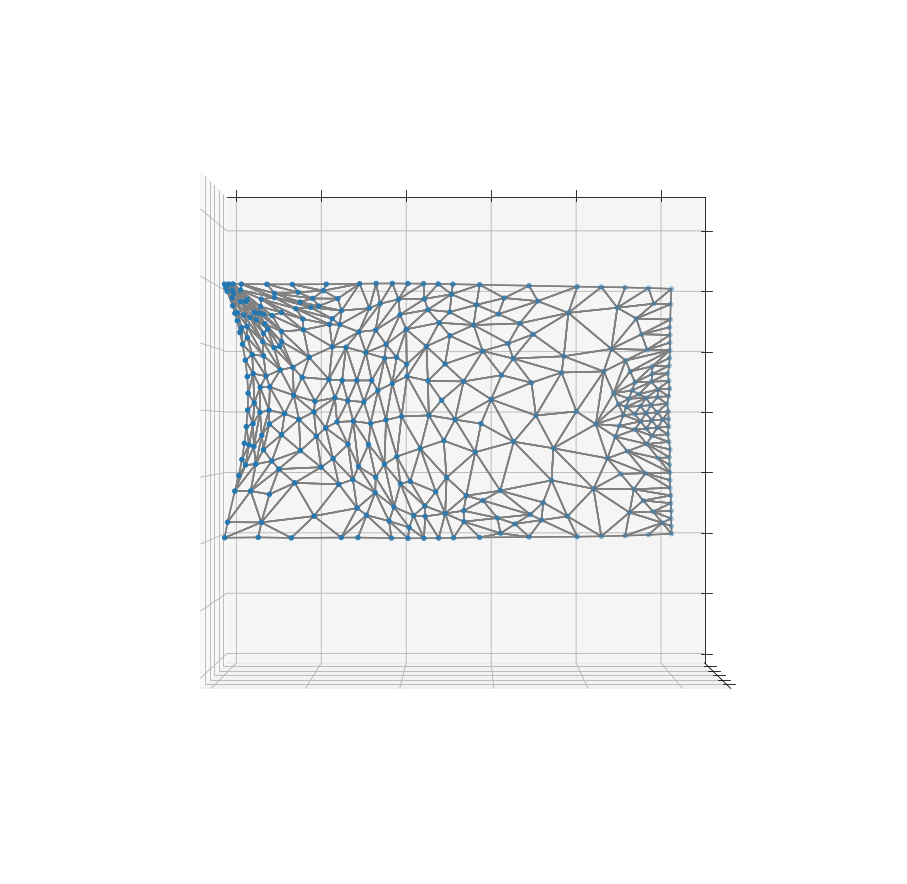

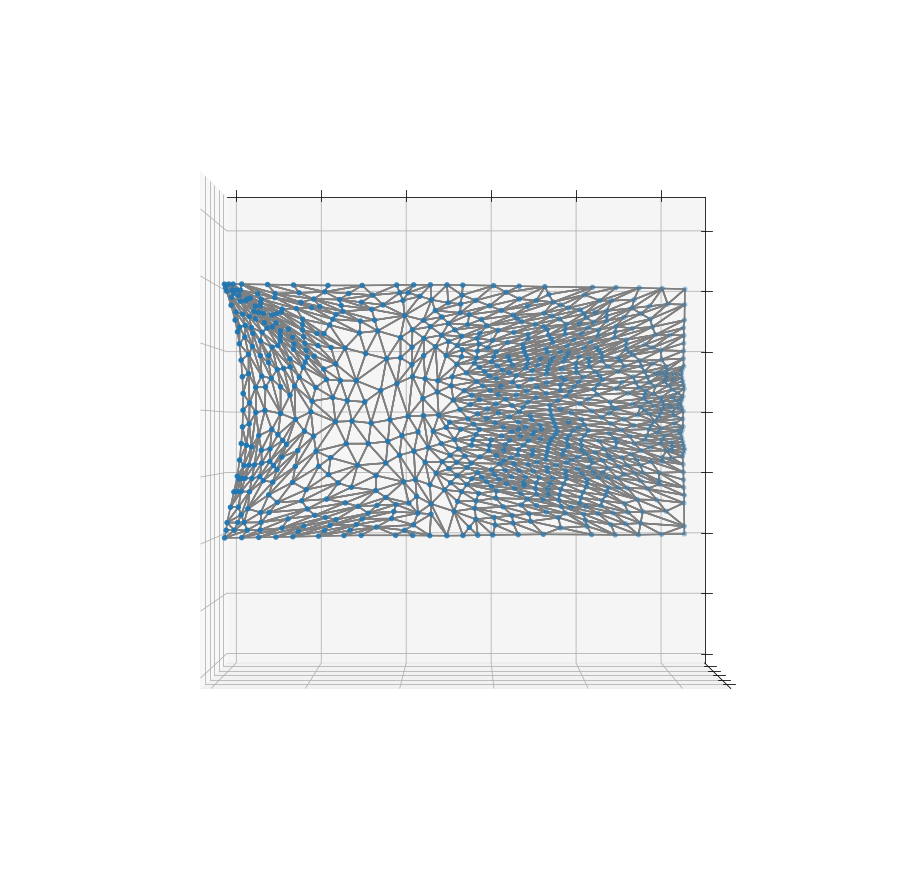

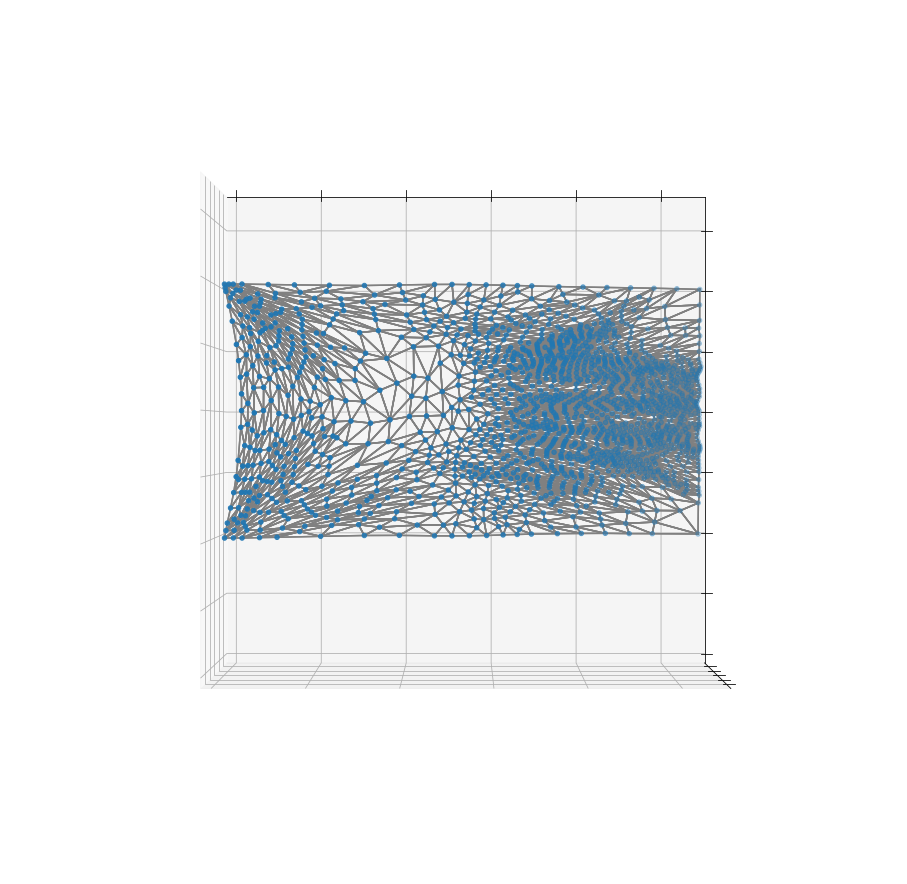

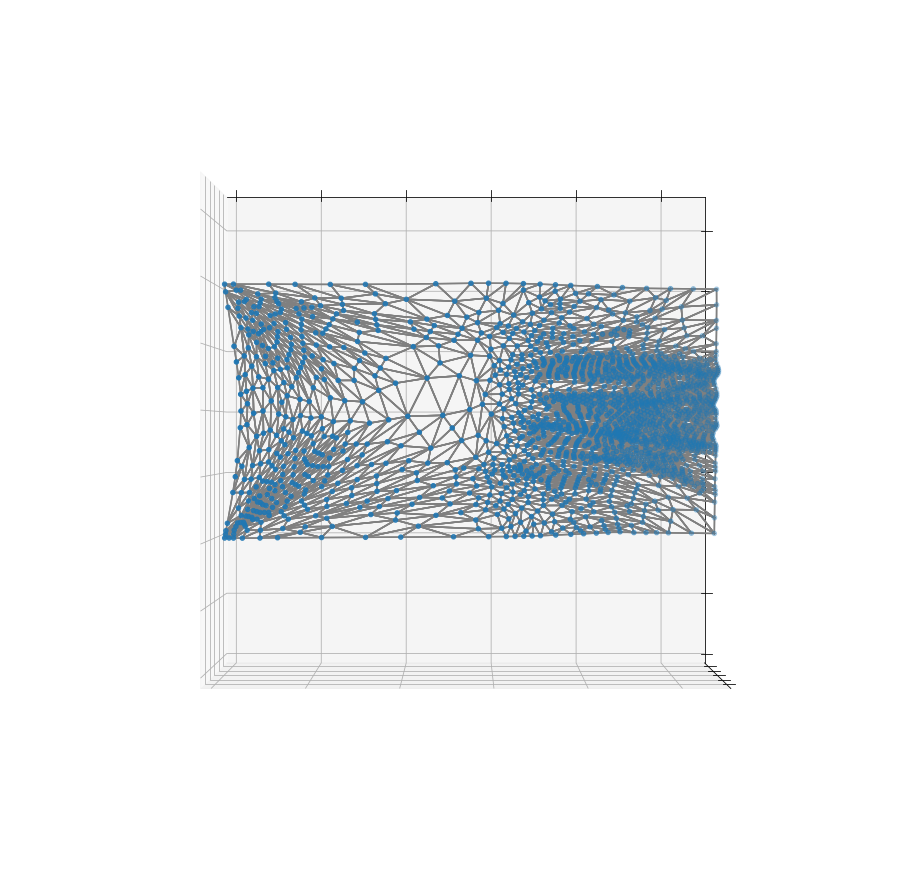

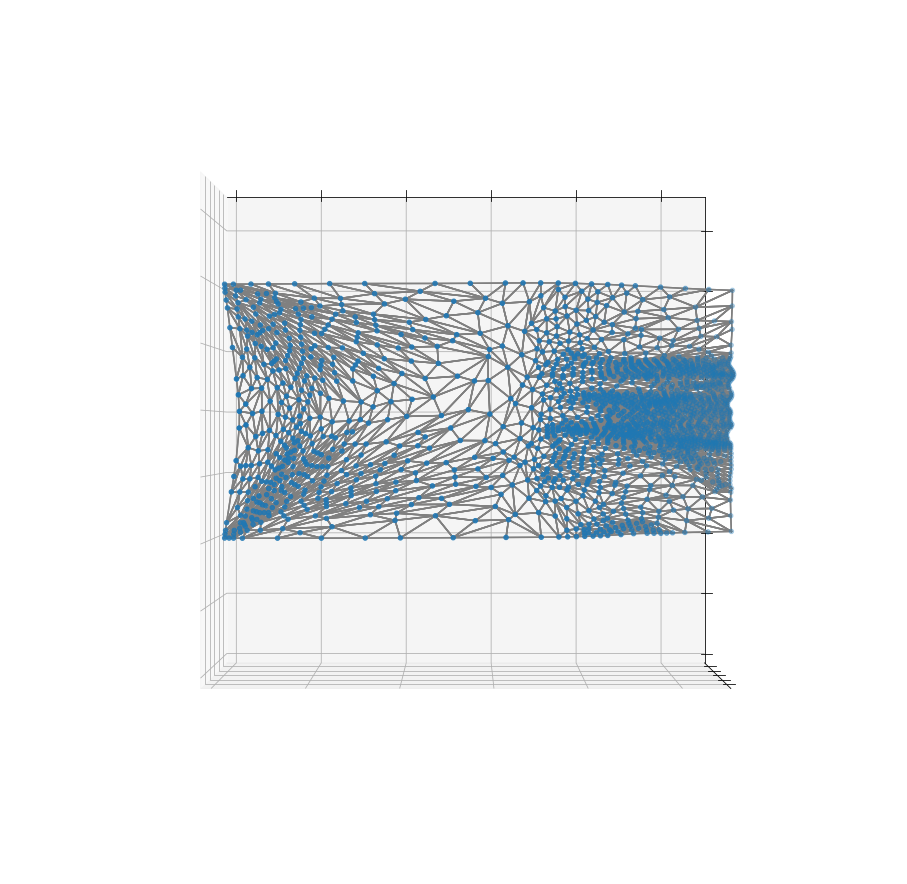

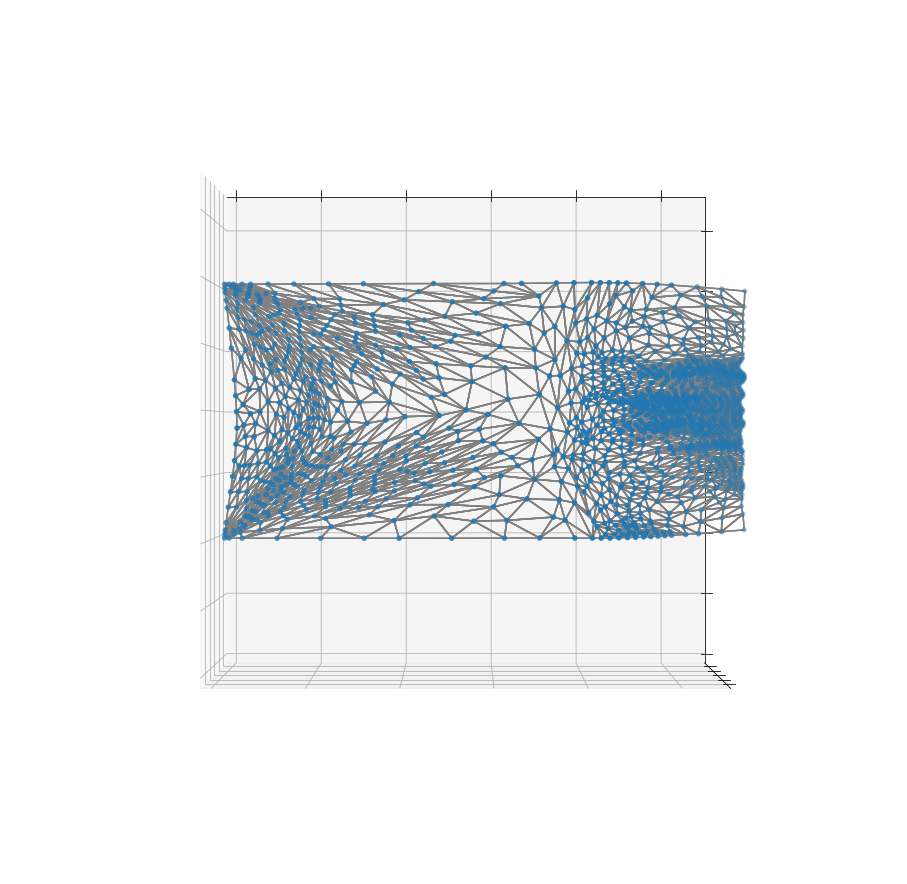

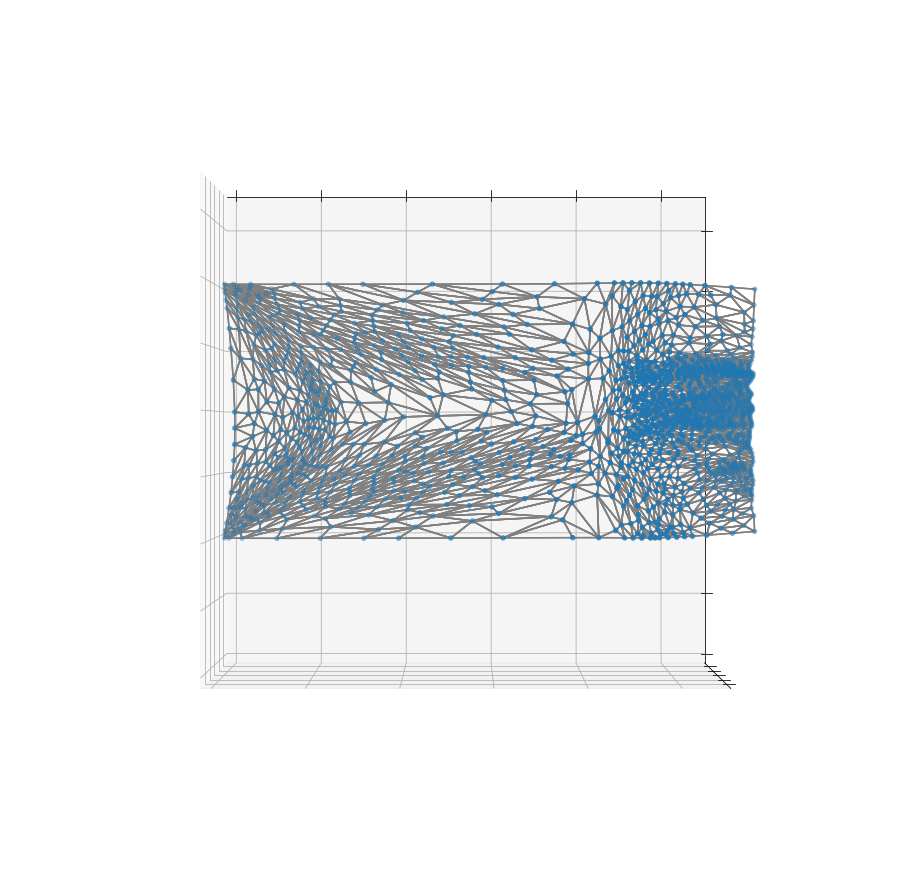

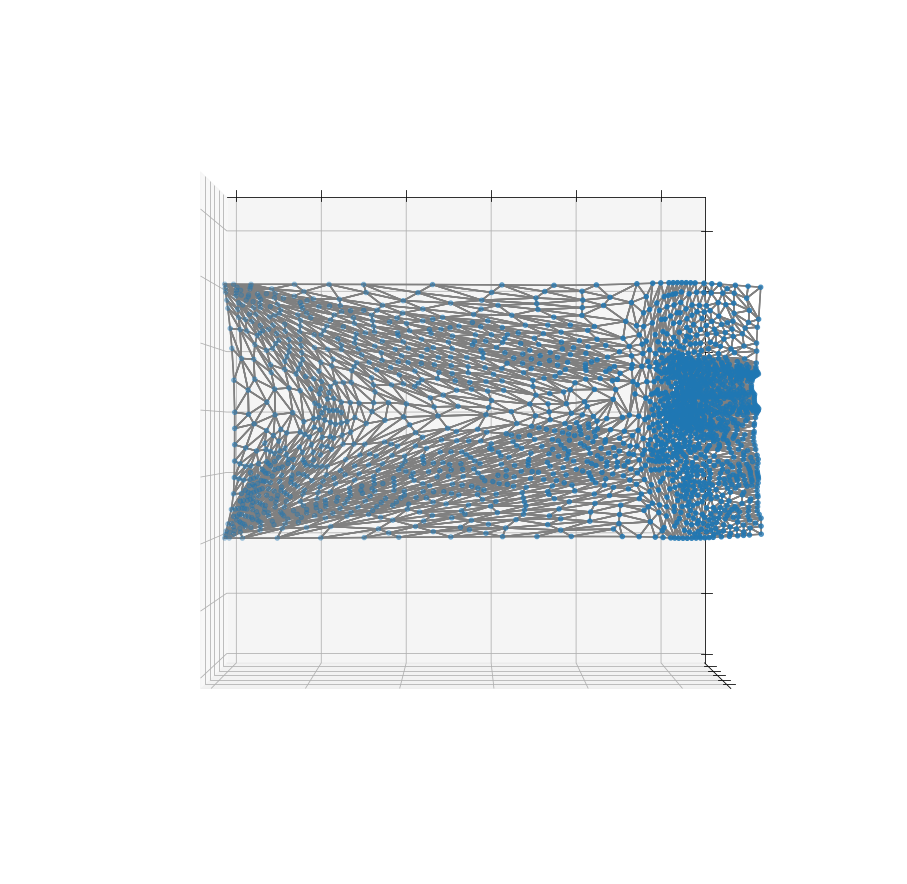

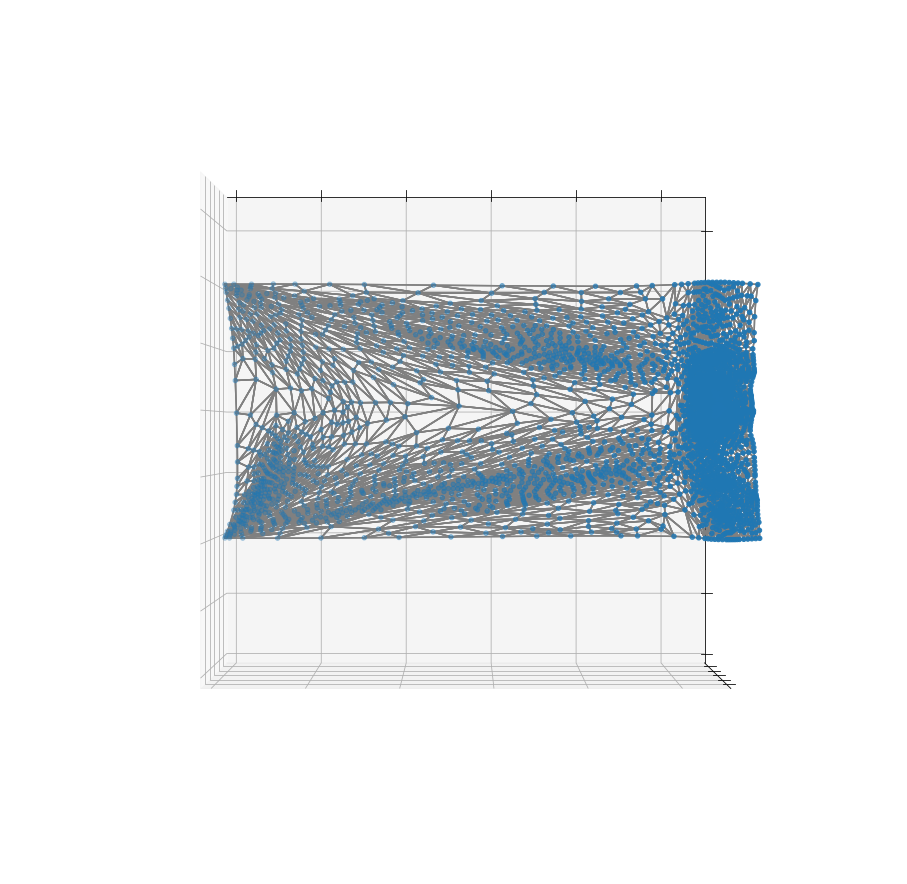

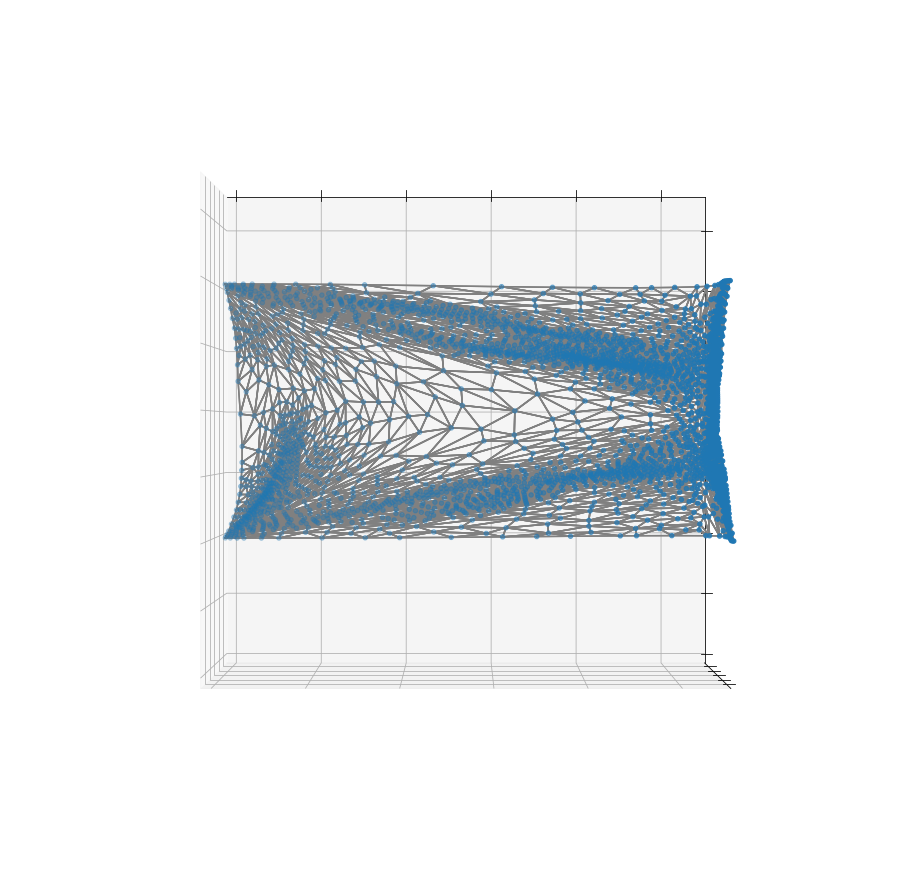

In [116]:
import matplotlib.pyplot as plt
for j in range(14):
    if j<10: path = 'data/0000'+str(j)+'_00.obj'
    else: path = 'data/000'+str(j)+'_00.obj'
    scene = pywavefront.Wavefront(path, collect_faces=True) # load ArcSim .obj file
    graph = obj_to_dgl(scene)
    # Data loading
    x = graph.ndata['x'].numpy()
    y = graph.ndata['y'].numpy()
    z = graph.ndata['z'].numpy()
    src, dst = graph.edges()


    # Plotting
    fig = plt.figure(figsize=(16,16))
    ax = fig.gca(projection='3d')
    lim=2.7
    ax.set_xlim3d(0, lim)
    ax.set_ylim3d(-1, lim)
    ax.set_zlim3d(-lim, lim)
    ax.view_init(90, -90)

    ax.scatter(x, y, z)
    for i in range(len(src)):
        s, d = src[i], dst[i]
        xs, ys, zs = np.array([x[s], x[d]]), np.array([y[s], y[d]]), np.array([z[s], z[d]])
        ax.plot(xs, ys, zs, color='grey')

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)
    plt.savefig('fig/flag' + str(j) + '.png')

In [ ]:
import shutil # check if ffmpeg is installed
assert shutil.which("ffmpeg"), "ffmpeg is not installed" 
import io
import base64
import os

t_dir = '/tmp/tmp8dn7yx5s'
from IPython.display import HTML
vid_fname = 'hs_residuals_random.mp4'
cmd = 'ffmpeg -r 16 -f image2 -i {}/flag%02d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)
os.system(cmd); print('Saving video to: {}'.format(vid_fname))

# Show video
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))